# Finetune a ResNet image classifier

## Load data

In [9]:
!curl -L https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/finetuning-resnet.zip -o data.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  15.9M      0  0:00:07  0:00:07 --:--:-- 22.7M


In [10]:
!unzip data.zip

Archive:  data.zip
   creating: train/
   creating: test/
   creating: train/muffin/
  inflating: train/muffin/muffin_38.jpeg  
  inflating: train/muffin/muffin_268.jpeg  
  inflating: train/muffin/muffin_142.jpeg  
  inflating: train/muffin/muffin_299.jpeg  
  inflating: train/muffin/muffin_54.jpeg  
  inflating: train/muffin/muffin_90.jpeg  
  inflating: train/muffin/muffin_312.jpeg  
  inflating: train/muffin/muffin_66.jpeg  
  inflating: train/muffin/muffin_424.jpeg  
  inflating: train/muffin/muffin_408.jpeg  
  inflating: train/muffin/muffin_392.jpeg  
  inflating: train/muffin/muffin_399.jpeg  
  inflating: train/muffin/muffin_62.jpeg  
  inflating: train/muffin/muffin_425.jpeg  
  inflating: train/muffin/muffin_86.jpeg  
  inflating: train/muffin/muffin_404.jpeg  
  inflating: train/muffin/muffin_233.jpeg  
  inflating: train/muffin/muffin_2.jpeg  
  inflating: train/muffin/muffin_156.jpeg  
  inflating: train/muffin/muffin_246.jpeg  
  inflating: train/muffin/muffin_286.jpeg  

## Establishing a baseline

Load an ImageNet pre-trained ResNet34, and check it's performance on the images in `data/test`.  

Use accuracy, precision and recall as your metrics for performance.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import datasets, transforms, models
from torchvision.models import ResNet34_Weights
from torch.utils.data import DataLoader, Subset, ConcatDataset, Sampler
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score

### Utilities

In [3]:
class FixedOrderSampler(Sampler):
    __slots = ("indices", )
    
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [38]:
class BinaryImageClassifier:
    __slots__ = ("__lr", "__l2_penalty", "pretrained", "device", "criterion", "train_loss_history", "test_loss_history",
                 "train_metrics_history", "test_results", "model", "optimizer", "train_loader", "test_loader")

    def __init__(self, *, lr, l2_penalty=0, pretrained=True, train_dir="./train", test_dir="./test"):
        self.__lr = lr
        self.__l2_penalty = l2_penalty
        self.pretrained = pretrained

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.criterion = nn.BCELoss()  # Binary Cross Entropy Loss
        self.train_loss_history = []
        self.test_loss_history = []
        self.train_metrics_history = []
        self.test_results = {}

        self.reload_model()

        self.train_loader = self.load_data(train_dir)
        self.test_loader = self.load_data(test_dir)


    @property
    def lr(self):
        return self.__lr

    @lr.setter
    def lr(self, val):
        self.__lr = val
        self.__reload_optimizer()


    @property
    def l2_penalty(self):
        return self.__l2_penalty

    @l2_penalty.setter
    def l2_penalty(self, val):
        self.__l2_penalty = val
        self.__reload_optimizer()


    def __reload_optimizer(self):
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.l2_penalty)


    def load_data(self, dir_, start=0, stop=None, step=1):
        self.__set_seed()

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        dataset = datasets.ImageFolder(root=dir_, transform=transform)

        # Shuffle the dataset
        indices = list(range(len(dataset)))
        random.shuffle(indices)
        indices = indices[start:stop:step]

        loader = DataLoader(dataset=dataset, batch_size=64, sampler=FixedOrderSampler(indices))
        return loader


    @staticmethod
    def __set_seed():
        seed = 42

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


    def reload_model(self):
        self.__set_seed()

        self.model = models.resnet34(weights=ResNet34_Weights.DEFAULT if self.pretrained else None).to(self.device)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 1),  # One final output
            nn.Sigmoid()
        ).to(self.device)
        self.__reload_optimizer()


    @staticmethod
    def __measure_metrics(y_true, y_pred):
        res = {}
        for metric_name, metric_fn in [("accuracy", accuracy_score),
                                       ("precision", lambda *args, **kwargs: precision_score(*args, **kwargs, zero_division=0)),  # to suppress warning
                                       ("recall", lambda *args, **kwargs: recall_score(*args, **kwargs, zero_division=0))]:
            res[metric_name] = metric_fn(y_true, y_pred)
        return res


    def fit(self, n_epochs, *, reset=True, show_progress=True):
        if reset:
            self.train_loss_history = []
            self.test_loss_history = []
            self.train_metrics_history = []
            self.reload_model()
        n_batches = len(self.train_loader)

        self.__set_seed()
        #self.model.train()  # Set model to training mode
        with tqdm(range(n_epochs * n_batches), desc="Training", ncols=150, disable=not show_progress) as pbar:
            for epoch in range(1, n_epochs + 1):
                for batch_idx, (batch_images, batch_labels) in enumerate(self.train_loader, 1):
                    batch_images, batch_labels = batch_images.to(self.device), batch_labels.float().reshape(-1, 1).to(self.device)

                    # Forward pass
                    self.model.train()  # Set model to training mode
                    batch_probas = self.model(batch_images)
                    batch_preds = batch_probas >= 0.5
                    batch_loss = self.criterion(batch_probas, batch_labels)

                    # Backward pass
                    self.optimizer.zero_grad()
                    batch_loss.backward()
                    self.optimizer.step()

                    # Record
                    self.train_metrics_history.append(self.__measure_metrics(batch_labels.cpu(), batch_preds.cpu()))
                    self.train_loss_history.append(batch_loss.item())
                    pbar.set_postfix(loss=f"{self.train_loss_history[-1]:.4f}")
                    pbar.update()

                # Evaluate after every epoch
                self.test_loss_history.append(self.predict(show_progress=False)["loss"])


    def plot_train(self, granularity=1):
        train_loss = self.train_loss_history[::granularity]
        x_iter = range(1, len(train_loss) * granularity + 1, granularity)

        n_iters = len(self.train_loss_history)
        n_epochs = len(self.test_loss_history)
        n_batches = int(n_iters / n_epochs) if n_epochs != 0 else 1
        test_loss = self.test_loss_history
        x_epoch = range(n_batches, n_iters + 1, n_batches)

        fig, axes = plt.subplots(1, 2, figsize=(13, 5))
        fig.suptitle(f"Loss and Performance Metrics During Training")

        # Left graph
        ax0 = axes[0]
        ax0.set_title("Loss")
        ax0.plot(x_iter, train_loss, label="train")
        ax0.plot(x_epoch, test_loss, label="test")
        ax0.set_xlabel("iteration")
        ax0.set_ylabel("loss")
        ax0.legend()

        # Right graph
        ax1 = axes[1]
        ax1.set_title("Training Performance")
        if len(self.train_metrics_history) > 0:
            for k in self.train_metrics_history[0].keys():
                ax1.plot(x_iter, [item[k] for item in self.train_metrics_history[::granularity]], label=k)
        ax1.set_xlabel("iteration")
        ax1.set_ylabel("score")
        ax1.set_ylim(0, 1)
        if ax1.get_legend_handles_labels()[0]:
            ax1.legend()

        return fig, axes


    def predict(self, *, show_progress=True):
        self.test_results = {"loss": 0, "probabilities": [], "predictions": []}
        all_labels = []

        self.__set_seed()
        self.model.eval()  # Set model to evaluation mode
        with tqdm(range(len(self.test_loader)), desc="Testing", ncols=150, disable=not show_progress) as pbar:
            with torch.no_grad():
                for batch_images, batch_labels in self.test_loader:
                    batch_images, batch_labels = batch_images.to(self.device), batch_labels.float().reshape(-1, 1).to(self.device)

                    # Predict
                    batch_probas = self.model(batch_images)
                    batch_preds = batch_probas >= 0.5

                    # Record
                    all_labels.extend(batch_labels.cpu().numpy())
                    self.test_results["probabilities"].extend(batch_probas.cpu().numpy().ravel().tolist())
                    self.test_results["predictions"].extend(batch_preds.cpu().numpy().astype(np.int8).ravel().tolist())
                    self.test_results["loss"] += self.criterion(batch_probas, batch_labels).item()
                    pbar.update()

        self.test_results["metrics"] = self.__measure_metrics(all_labels, self.test_results["predictions"])
        return self.test_results

### Performance without training

In [39]:
clf = BinaryImageClassifier(lr=0.001)

In [40]:
out = clf.predict()
out["loss"], out["metrics"]

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.69it/s]


(0.8405465483665466,
 {'accuracy': 0.3125, 'precision': 0.38461538461538464, 'recall': 0.625})

## Finetuning

Finetune this ResNet using data in `data/train`. Use `data/test` as your testing set, and use cross entropy loss. The rest is up to you. Run finetuning that terminates within approx 10 mins. Store the following info every 10 minibatches: loss, precision, recall and accuracy on train and test datasets.

In [41]:
# Freeze all parameters except those in the fc layer
for param in clf.model.parameters():
    param.requires_grad = False

for param in clf.model.fc.parameters():
    param.requires_grad = True

> The following cell takes ~3 mins to run on a T4 GPU.

In [45]:
clf.fit(n_epochs=10)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 160/160 [03:28<00:00,  1.30s/it, loss=0.0016]


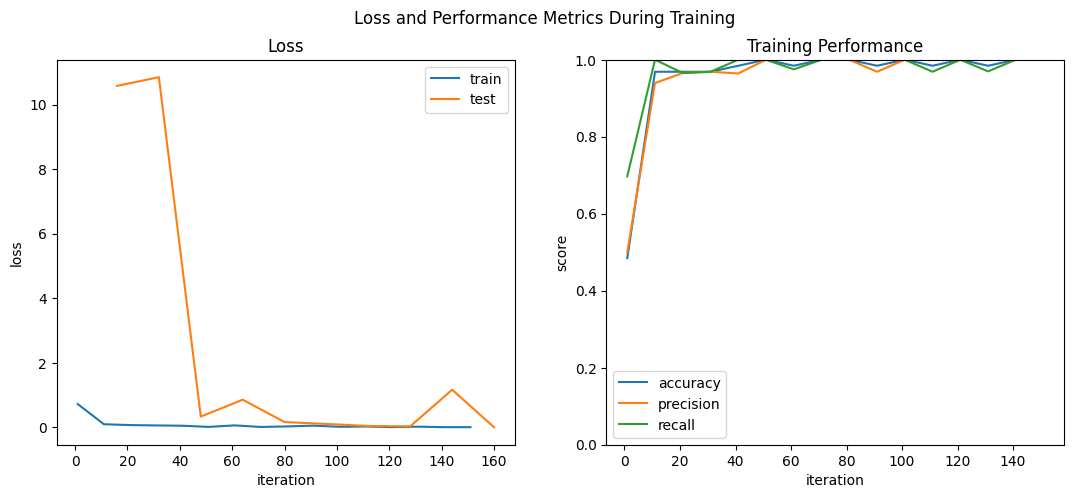

In [46]:
clf.plot_train(granularity=10);

In [47]:
out = clf.predict()
out["loss"], out["metrics"]

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.65it/s]


(0.00047923269448801875, {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0})

In [48]:
torch.save(clf.model.state_dict(), 'resnet34_finetuned.pth')

## Writeup

Summarize what you did above, as well as detail the choices you made and why. What was the outcome?

---

A ResNet34 classifies [1000 classes](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/), one of which is chihuahua. Likely because of this, we achieved a perfect score on the test set with minimal fine-tuning.

We loaded a pretrained ResNet34 model and replaced its final fully connected (FC) layer so that it produces a single output. This output is then passed through a sigmoid activation to clamp the value between 0 and 1.

We frozen all other layers and trained only the new FC layer. In 10 epochs, both the training and test loss decreased steadily, and finally the model reached 100% accuracy.

Before moving on, I would like to discuss some mistakes I made while making the code deterministic. I spent a lot of time on repetitive tasks as the hyperparameters obtained did not reproduce the same results, and often the performance was very different!

1. I used to call `self.__set_seed()` only in the `__init__` method. However, during the tuning process, I found that the results were not the same each time I called `fit()`. I then realized that I should set the seed every time before training and testing, not just once during initialization.
   
2. When using `DataLoader(dataset, batch_size)`, I was getting batches with all zeros followed by ones. I wanted to achieve a mix of zeros and ones in each batch (which is necessary for the next section). My initial attempt was to use `shuffle=True`, but I later realized that it shuffles the dataset at the start of each epoch, causing different runs to produce different results. Eventually, I came up with a solution by writing a custom sampler and manually shuffling the dataset.

   ```python
    class FixedOrderSampler(Sampler):
    ...

    class BinaryImageClassifier:
        ...
        def load_data(self, ...):
            ...
            indices = list(range(len(dataset)))
            random.shuffle(indices)
            indices = indices[start:stop:step]
            
            loader = DataLoader(dataset=dataset, batch_size=64, sampler=FixedOrderSampler(indices))
        ...
    ```

However, the behavior still differs between Colab and my local Jupyter Notebook for reasons that are unknown to me.

## Further analysis

Pick one aspect about the work done above thus far that you find interesting, investigate it a bit further, and give a short paragraph writeup of what you investigated and how it went.

---

### Defining the problem

The original problem was relatively easy to train. To make it more challenging, we impose the following restrictions:

- Limit the training set to 400 images.
- Remove pretrained weights (i.e., start ResNet from scratch).

Our objective is to maximize classification performance (the accuracy, precision, and recall) under these constraints by tuning only three hyperparameters:

- Learning rate (`lr`)
- Number of epochs (`n_epochs`)
- L2 penalty (`l2_penalty`), which corresponds to `weight_decay` in `torch.optim.Adam`

We do not consider any other modifications beyond these adjustments.

### Setup

In [49]:
clfx = BinaryImageClassifier(lr=0.001, pretrained=False)
clfx.train_loader = clfx.load_data("./train", 0, 400)
clfx.test_loader = clfx.load_data("./train", 400, 500)

len(clfx.train_loader.sampler), len(clfx.test_loader.sampler)

(400, 100)

Here comes the significance of shuffling the images (as mentioned in the "Writeup" section). We don't want the model to train on batches where all images are labeled as zeros.

Besides, we set aside 100 images from the `./train` folder as the test set. A larger test set would provide more stable and reliable performance estimates.

### Tuning

### Learning rate

> The following cell takes ~15 mins to run on a T4 GPU.

In [50]:
his = []
for lr_exp in range(-5, 0):
    clfx.l2_penalty = 0
    clfx.lr = 10 ** lr_exp
    print(f"Experimenting lr={clfx.lr}...")

    clfx.fit(20)
    his.append((clfx.lr, clfx.train_loss_history, clfx.test_loss_history))

Experimenting lr=1e-05...


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 140/140 [03:01<00:00,  1.30s/it, loss=0.0055]


Experimenting lr=0.0001...


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 140/140 [03:17<00:00,  1.41s/it, loss=0.0004]


Experimenting lr=0.001...


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 140/140 [03:16<00:00,  1.40s/it, loss=0.0146]


Experimenting lr=0.01...


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 140/140 [03:04<00:00,  1.32s/it, loss=0.1015]


Experimenting lr=0.1...


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 140/140 [03:01<00:00,  1.30s/it, loss=0.0616]


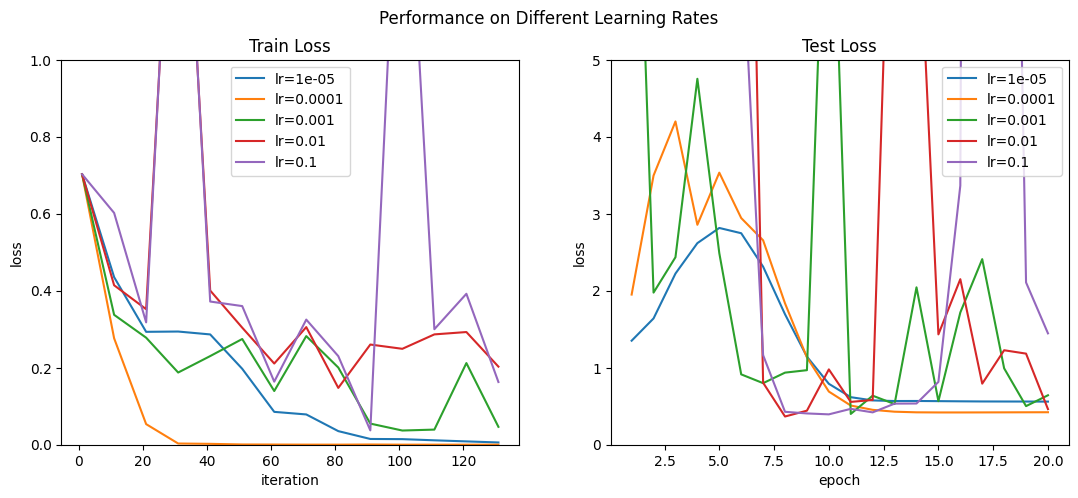

In [61]:
granularity = 10
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Performance on Different Learning Rates")

# Left graph
ax0 = axes[0]
for lr, train_loss, _ in his:
    ax0.plot(range(1, len(train_loss[::granularity]) * granularity + 1, granularity), train_loss[::granularity], label=f"lr={lr}")
ax0.set_xlabel("iteration")
ax0.set_ylabel("loss")
ax0.set_title("Train Loss")
ax0.set_ylim(0, 1)
ax0.legend()

# Right graph
ax1 = axes[1]
for lr, _, test_loss in his:
    ax1.plot(range(1, len(test_loss) + 1), test_loss, label=f"lr={lr}")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.set_title("Test Loss")
ax1.set_ylim(0, 5)
ax1.legend();

### Number of epochs

Using the best `lr` found from the graph above, we now train for 50 epochs to take a closer look on how the test loss evolves over time.

> The following cell takes ~7 mins to run on a T4 GPU.

In [62]:
clfx.lr = 0.0001
clfx.l2_penalty = 0
clfx.fit(50)

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 350/350 [07:30<00:00,  1.29s/it, loss=0.0002]


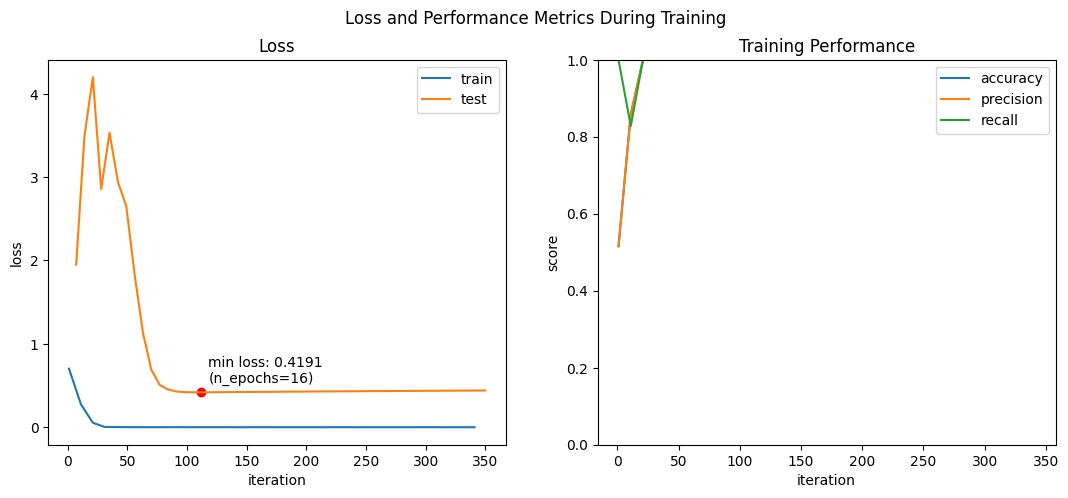

In [63]:
fig, axes = clfx.plot_train(10)

min_idx = np.argmin(clfx.test_loss_history)
min_x = (min_idx + 1) * len(clfx.train_loader)
min_y = clfx.test_loss_history[min_idx]

axes[0].scatter(min_x, min_y, color='red')
axes[0].annotate(f'min loss: {min_y:.4f}\n(n_epochs={min_idx + 1})', (min_x, min_y), textcoords="offset points", xytext=(5,7));

### L2 penalty

After some empirical testing, it appears that adding an L2 penalty did not improve the scores. Therefore, we set it to zero. Our final result is:

In [67]:
clfx.lr = 0.0001
clfx.l2_penalty = 0
clfx.fit(16)

out = clfx.predict()
out["loss"], out["metrics"]

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.26it/s]


(0.4355408102273941,
 {'accuracy': 0.93, 'precision': 0.9375, 'recall': 0.9183673469387755})

In [65]:
torch.save(clfx.model.state_dict(), 'resnet34_manual400.pth')

## Auto tuning

In this section, we utilize Optuna to automatically tune our hyperparameters. Optuna automates hyperparameter tuning using Bayesian optimization. It smartly selects hyperparameter configurations based on past trial outcomes, focusing on promising regions of the search space.

In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.8 MB/s eta 0:00:00


In [6]:
import optuna
import optuna.visualization as vis

In [11]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    n_epochs = trial.suggest_int('n_epochs', 1, 20)
    l2_penalty = trial.suggest_float('l2_penalty', 1e-6, 1e-1, log=True)

    clfy = BinaryImageClassifier(lr=lr, l2_penalty=l2_penalty, pretrained=False)

    clfy.train_loader = clfy.load_data("./train", 0, 400)
    clfy.test_loader = clfy.load_data("./train", 400, 500)

    clfy.fit(n_epochs)
    out = clfy.predict()
    return *out["metrics"].values(), out["loss"]

> The following cell takes ~1 hour to run on a T4 GPU.

In [13]:
study = optuna.create_study(directions=["maximize", "maximize", "maximize", "minimize"],
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30)

[I 2025-04-05 03:37:27,015] A new study created in memory with name: no-name-dce75799-f6ba-46d9-8983-7fcc6eebc862
Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.17it/s]
[I 2025-04-05 03:40:42,007] Trial 0 finished with values: [0.81, 0.96875, 0.6326530612244898, 1.2829756140708923] and parameters: {'lr': 0.00031489116479568613, 'n_epochs': 20, 'l2_penalty': 0.004570563099801453}.
Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.16s/it]
[I 2025-04-05 03:41:22,401] Trial 1 finished with values: [0.86, 0.8723404255319149, 0.8367346938775511, 4.320414245128632] and parameters: {'lr': 0.0024810409748678114, 'n_epochs': 4, 'l2_penalty': 6.025215736203862e-06}.
Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.10it

In [18]:
vis.plot_optimization_history(
    study,
    target=lambda t: t.values[0],
    target_name="Accuracy"
)

In [19]:
vis.plot_slice(
    study,
    target=lambda t: t.values[0],
    target_name="Accuracy"
)

In [68]:
vis.plot_param_importances(
    study,
    target=lambda t: t.values[0],
    target_name="Accuracy"
)

In [15]:
study.best_trials

[FrozenTrial(number=5, state=1, values=[0.69, 1.0, 0.3673469387755102, 1.6563652157783508], datetime_start=datetime.datetime(2025, 4, 5, 3, 45, 11, 441808), datetime_complete=datetime.datetime(2025, 4, 5, 3, 46, 18, 255138), params={'lr': 5.415244119402538e-05, 'n_epochs': 7, 'l2_penalty': 0.0004205156450913873}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'n_epochs': IntDistribution(high=20, log=False, low=1, step=1), 'l2_penalty': FloatDistribution(high=0.1, log=True, low=1e-06, step=None)}, trial_id=5, value=None),
 FrozenTrial(number=8, state=1, values=[0.83, 0.75, 0.9795918367346939, 1.2331213355064392], datetime_start=datetime.datetime(2025, 4, 5, 3, 48, 14, 140739), datetime_complete=datetime.datetime(2025, 4, 5, 3, 50, 44, 96088), params={'lr': 0.0006672367170464204, 'n_epochs': 16, 'l2_penalty': 9.962513222055122e-06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributi

In [22]:
best_params = study.trials[19].params
best_params

{'lr': 0.00023506997063237137,
 'n_epochs': 20,
 'l2_penalty': 0.00019174179258583216}

In [17]:
study.trials[19].values

[0.97, 0.9791666666666666, 0.9591836734693877, 0.3444816321134567]

In [23]:
clfy = BinaryImageClassifier(lr=best_params["lr"], l2_penalty=best_params["l2_penalty"], pretrained=False)

clfy.train_loader = clfy.load_data("./train", 0, 400)
clfy.test_loader = clfy.load_data("./train", 400, 500)

clfy.fit(best_params["n_epochs"])

Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 140/140 [02:54<00:00,  1.24s/it, loss=0.0006]


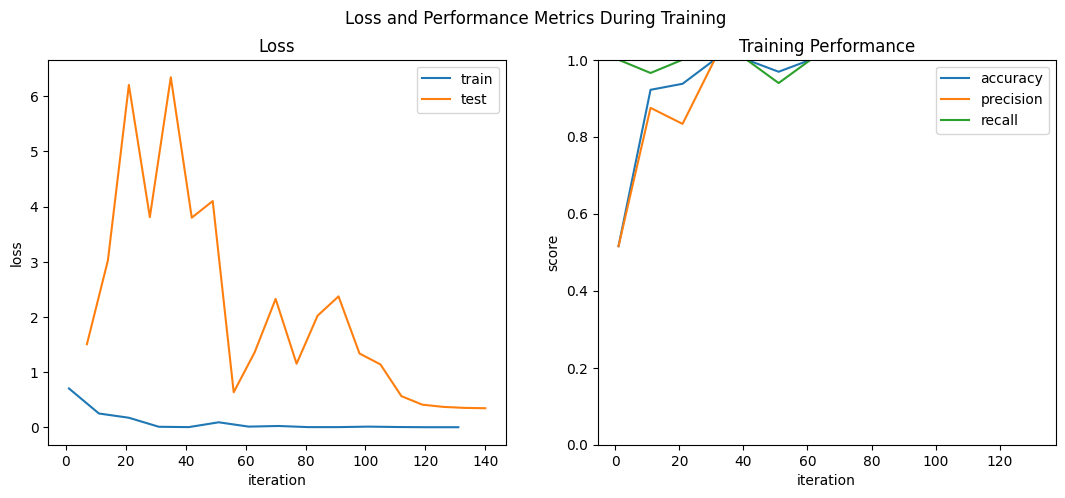

In [25]:
clfy.plot_train(10);

In [26]:
out = clfy.predict()
out["loss"], out["metrics"]

Testing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.28it/s]


(0.3444816321134567,
 {'accuracy': 0.97,
  'precision': 0.9791666666666666,
  'recall': 0.9591836734693877})

In [66]:
torch.save(clfy.model.state_dict(), 'resnet34_auto400.pth')

## Conclusion

| | Parameters | Accuracy | Precision | Recall | Loss |
| --- | --- | --- | --- | --- | --- |
| Manual | `lr=1.000e-4, n_epochs=16, l2_penalty=0.000` | 0.9300 | 0.9375 | 0.9184 | 0.4191 |
| Optuna | `lr=2.351e-4, n_epochs=20, l2_penalty=1.917e-4` | 0.9700 | 0.9792 | 0.9592 | 0.3445 |

(Correct to 4 sig. fig.)

The results demonstrate that the Optuna-optimized model outperformed the manually tuned counterpart across all evaluation metrics, achieving higher accuracy, precision, and recall, while also reducing the loss.

This highlights the effectiveness of automated hyperparameter optimization in improving model performance and reducing the need for extensive manual experimentation. Also, the manual approach of "tuning one parameter at a time" may be suboptimal, as hyperparameters often interact in non-orthogonal ways: changes in one can influence the optimal values of others.